<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#283618;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    Supervised Learning Approach - CNN
             </p> </div>

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
  Libraries
             </p> </div>

In [3]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xml.etree.ElementTree as ET
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import tqdm
import tensorflow as tf

2024-04-12 17:14:45.168779: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 17:14:45.168886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 17:14:45.308180: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    Get the Data
             </p> </div>

In [4]:
# Path to the downloaded dataset
dataset_dir = "/kaggle/input/face-mask-detection"



# Function to load images and annotations
def load_dataset(dataset_dir):
    images_dir = os.path.join(dataset_dir, "images")
    annotations_dir = os.path.join(dataset_dir, "annotations")
    
    images = []
    labels = []
    for filename in os.listdir(annotations_dir):
        if filename.endswith(".xml"):
            xml_path = os.path.join(annotations_dir, filename)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            for obj in root.findall('object'):
                label = obj.find('name').text
                label = 'with_mask' if label == 'with_mask' else 'without_mask'  # Assuming binary classification
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                image_path = os.path.join(images_dir, root.find('filename').text)
                image = cv2.imread(image_path)
                image = image[ymin:ymax, xmin:xmax]  # Crop the image based on bounding box
                image = cv2.resize(image, (224, 224))  # Resize the image to a standard size
                images.append(image)
                labels.append(label)
    if not images or not labels:
        print("Error: No data loaded from the dataset.")
        return None, None
    
    return np.array(images), np.array(labels)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
 Exploring the Data
             </p> </div>

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


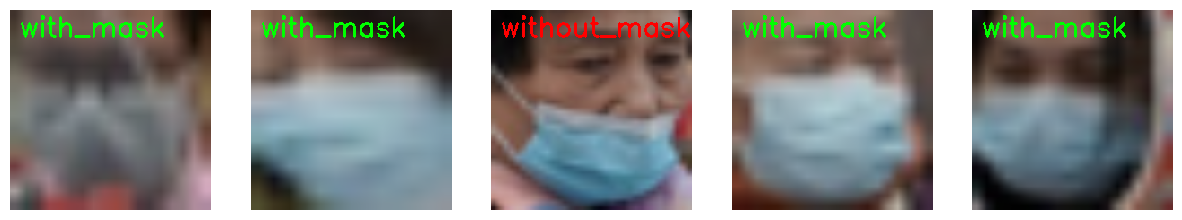

In [5]:

# Load dataset
images, labels = load_dataset(dataset_dir)

# Assign colors to labels
label_colors = {
    'with_mask': (0, 255, 0),  # Green
    'without_mask': (0, 0, 255),  # Red
    }

# Function to visualize images with annotations
def visualize_images_with_annotations(images, labels, label_colors, num_images=5):
    # Visualize a subset of images
    num_images = min(num_images, len(images))
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        # Display image with annotations
        image = images[i].copy()
        label = labels[i]
        color = label_colors[label]
        image_with_label = cv2.putText(image, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
        axes[i].imshow(cv2.cvtColor(image_with_label, cv2.COLOR_BGR2RGB), interpolation='nearest')
        axes[i].axis('off')
    plt.show()

# Example usage
visualize_images_with_annotations(images, labels, label_colors, num_images=5)

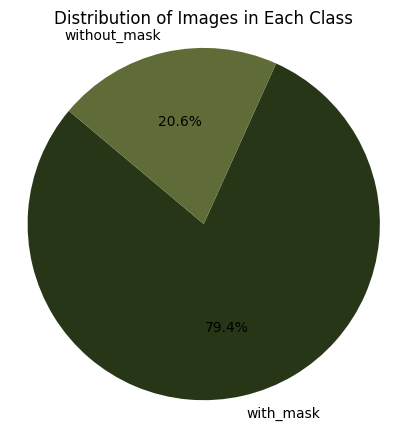

In [7]:
# Count the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Define colors for each class
class_colors = {
    'with_mask': '#283618',
    'without_mask': '#606c38'
    }

# Create a list of colors corresponding to each label
colors = [class_colors[label] for label in unique_labels]

# Create a pie plot with custom colors
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=unique_labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of Images in Each Class')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    Split the Data
             </p> </div>

In [8]:
# Load the dataset
X, y = load_dataset(dataset_dir)

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [9]:
set(y)

{'with_mask', 'without_mask'}

In [10]:
len(y)

4072

In [12]:
Counter(y)

Counter({'with_mask': 3232, 'without_mask': 840})

In [13]:
X.shape

(4072, 224, 224, 3)

In [14]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(y)

labels_encoded = to_categorical(labels_encoded)

In [15]:
X.shape, y.shape

((4072, 224, 224, 3), (4072,))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, labels_encoded, test_size=0.30,stratify=labels_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50,stratify=y_test, random_state=42)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    CNN
             </p> </div>

In [18]:
image_height, image_width,num_channels

(224, 224, 3)

In [19]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,186 (84.86 MB)

 Trainable params: 22,245,186 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    Train the Model
             </p> </div>

In [21]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training with callbacks and validation set
history = model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.7915 - loss: 21.0653 - val_accuracy: 0.7905 - val_loss: 2086.9673
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.7814 - loss: 670.8210 - val_accuracy: 0.7938 - val_loss: 37500.8711
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7905 - loss: 72.3668 - val_accuracy: 0.7938 - val_loss: 1987.4955
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8030 - loss: 346.8049 - val_accuracy: 0.7938 - val_loss: 27543.1973
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7924 - loss: 97.2569 - val_accuracy: 0.7938 - val_loss: 8344.6035
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7896 - loss: 35.4360 - val_accuracy: 0.7938 - val_loss: 1641.6614
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7912 - loss: 8.7785 - val_accuracy: 0.7921 - val_loss: 31.8393


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    Model Evaluation
             </p> </div>

In [25]:
#test data
model.evaluate(X_test, y_test, verbose=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7662 - loss: 2316.4651


[24236.646484375, 0.7921440005302429]

In [26]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

classification_rep = classification_report(y_test_labels, y_pred_labels)

print(classification_rep)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       485
           1       0.00      0.00      0.00       126

    accuracy                           0.79       611
   macro avg       0.40      0.50      0.44       611
weighted avg       0.63      0.79      0.70       611



In [27]:
# Find the class that was predicted wrong the most
wrong_predictions = np.where(y_pred_labels != y_test_labels)[0]
wrong_classes = y_test_labels[wrong_predictions]
most_wrong_class = Counter(wrong_classes).most_common(1)[0][0]

print(f"The class predicted wrong the most is: {most_wrong_class}")

The class predicted wrong the most is: 1


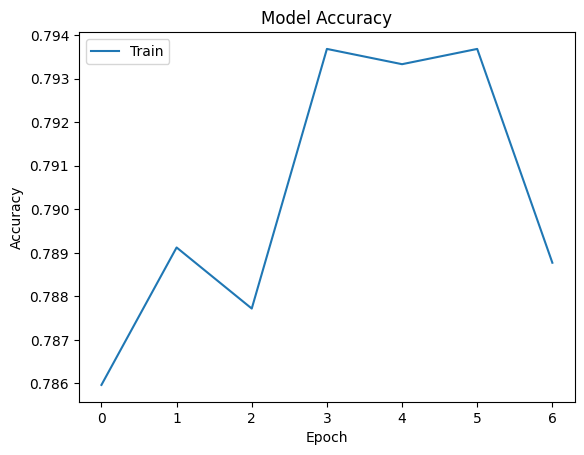

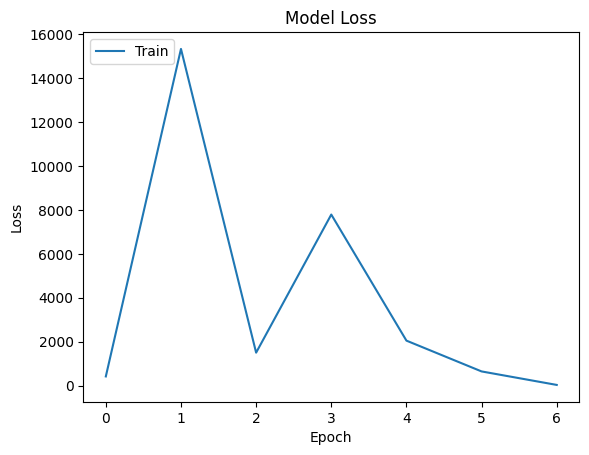

In [28]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [29]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


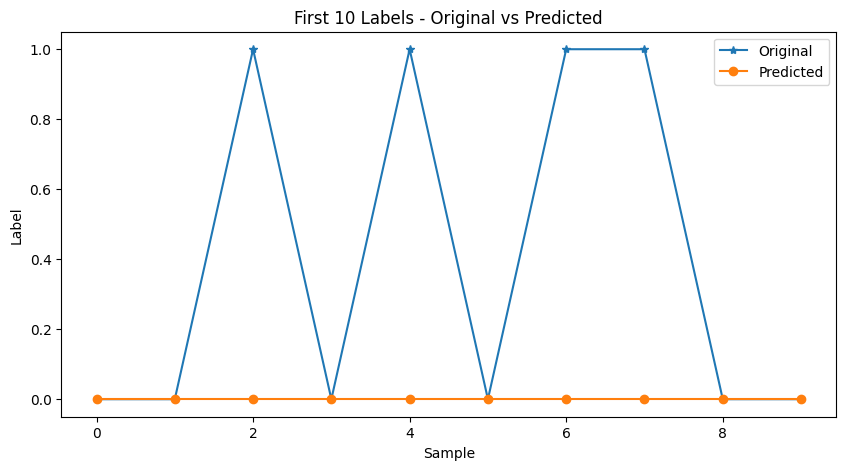

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_labels[:10], '*-', label='Original')
plt.plot(y_pred_labels[:10], 'o-', label='Predicted')
plt.title('First 10 Labels - Original vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Label')
plt.legend()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    Display Prediction
             </p> </div>

In [31]:
sample_labels_true = label_encoder.inverse_transform(y_test_labels)
sample_labels_pred = label_encoder.inverse_transform(y_pred_labels)

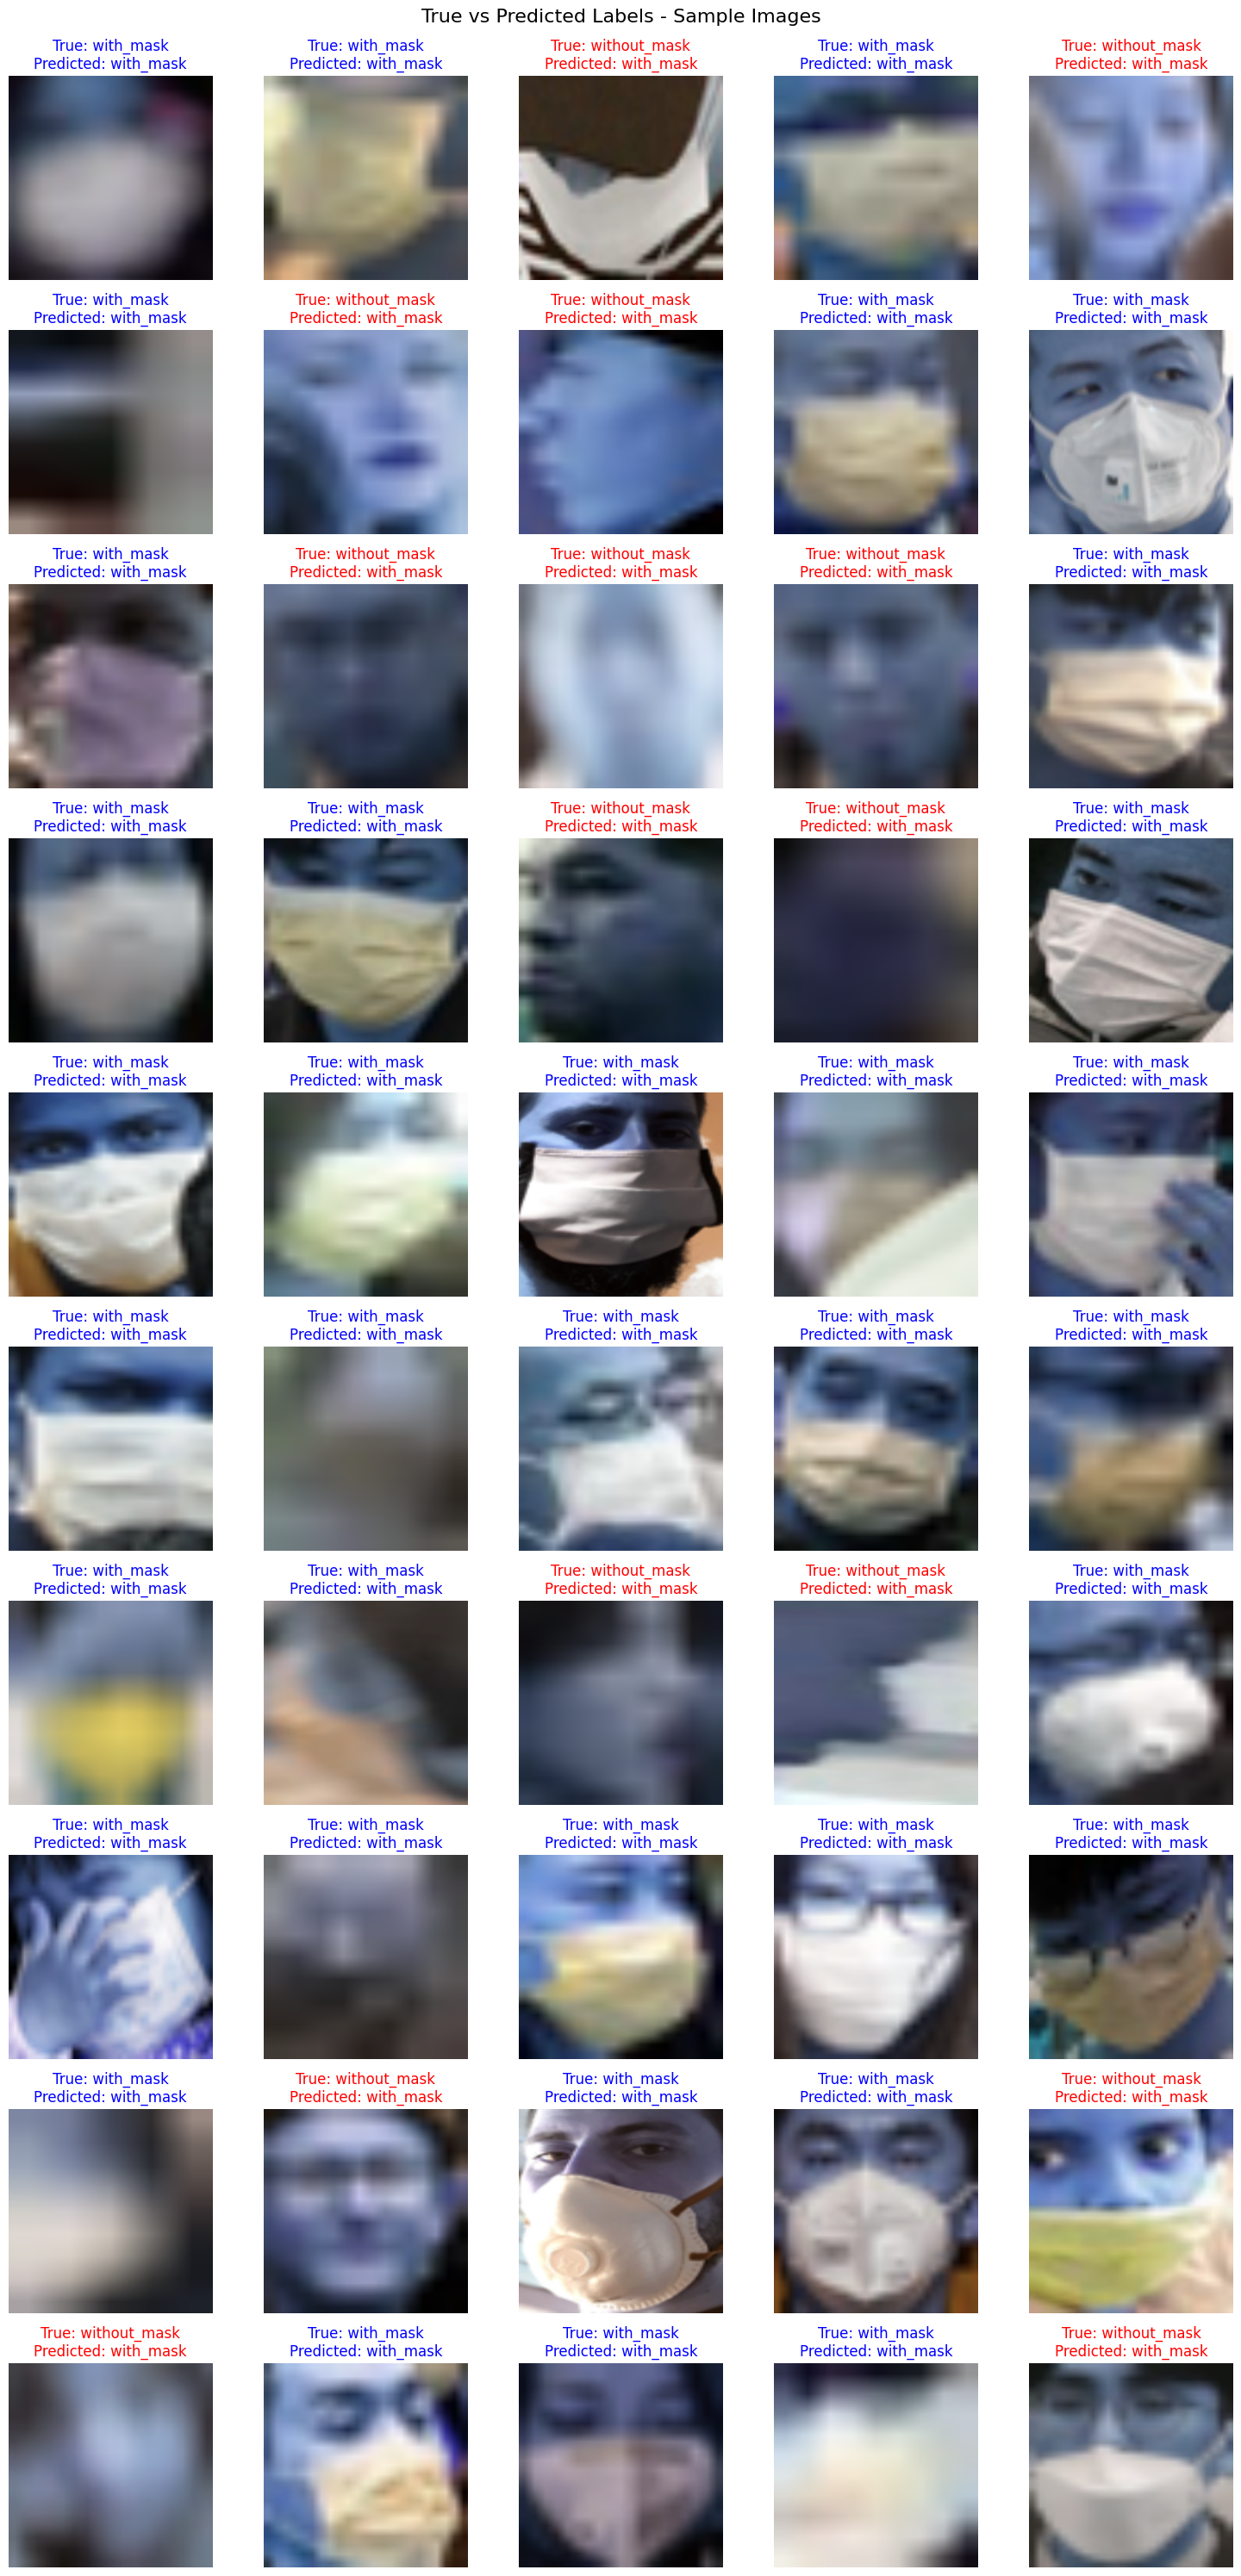

In [32]:
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(15, 30))
fig.suptitle('True vs Predicted Labels - Sample Images', fontsize=16,y=0.995) 

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i])
    title = ax.set_title(f'True: {sample_labels_true[i]}\nPredicted: {sample_labels_pred[i]}')
    if sample_labels_true[i] != sample_labels_pred[i]:
        title.set_color('red')
    else:
        title.set_color('blue')
    ax.axis('off')

plt.tight_layout()
plt.show()